In [1]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns


# Data Visualization
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d 
import matplotlib.ticker as mticker

# Data Classification
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report

# ---- Getting a grasp on the data ----

In [2]:
# Loading the data 
df = pd.read_csv('final_test.csv')

# Cleaning data 
df.dropna(inplace=True)
print(df.isna().sum())

# Removing age outliers
df = df[df['age'] > 9]
df = df[df['age'] < 90]

# Summary of the data
print(df.describe())

weight    0
age       0
height    0
size      0
dtype: int64
              weight            age         height
count  119055.000000  119055.000000  119055.000000
mean       61.759078      34.014993     165.807714
std         9.941482       7.978889       6.737609
min        22.000000      14.000000     137.160000
25%        55.000000      29.000000     160.020000
50%        61.000000      32.000000     165.100000
75%        67.000000      37.000000     170.180000
max       136.000000      88.000000     193.040000


This will be the base for which the rest of the analysis is done. There is a couple of thing to notice right off the bat:
- The data is skewed right
- We will need to need to handle outliers

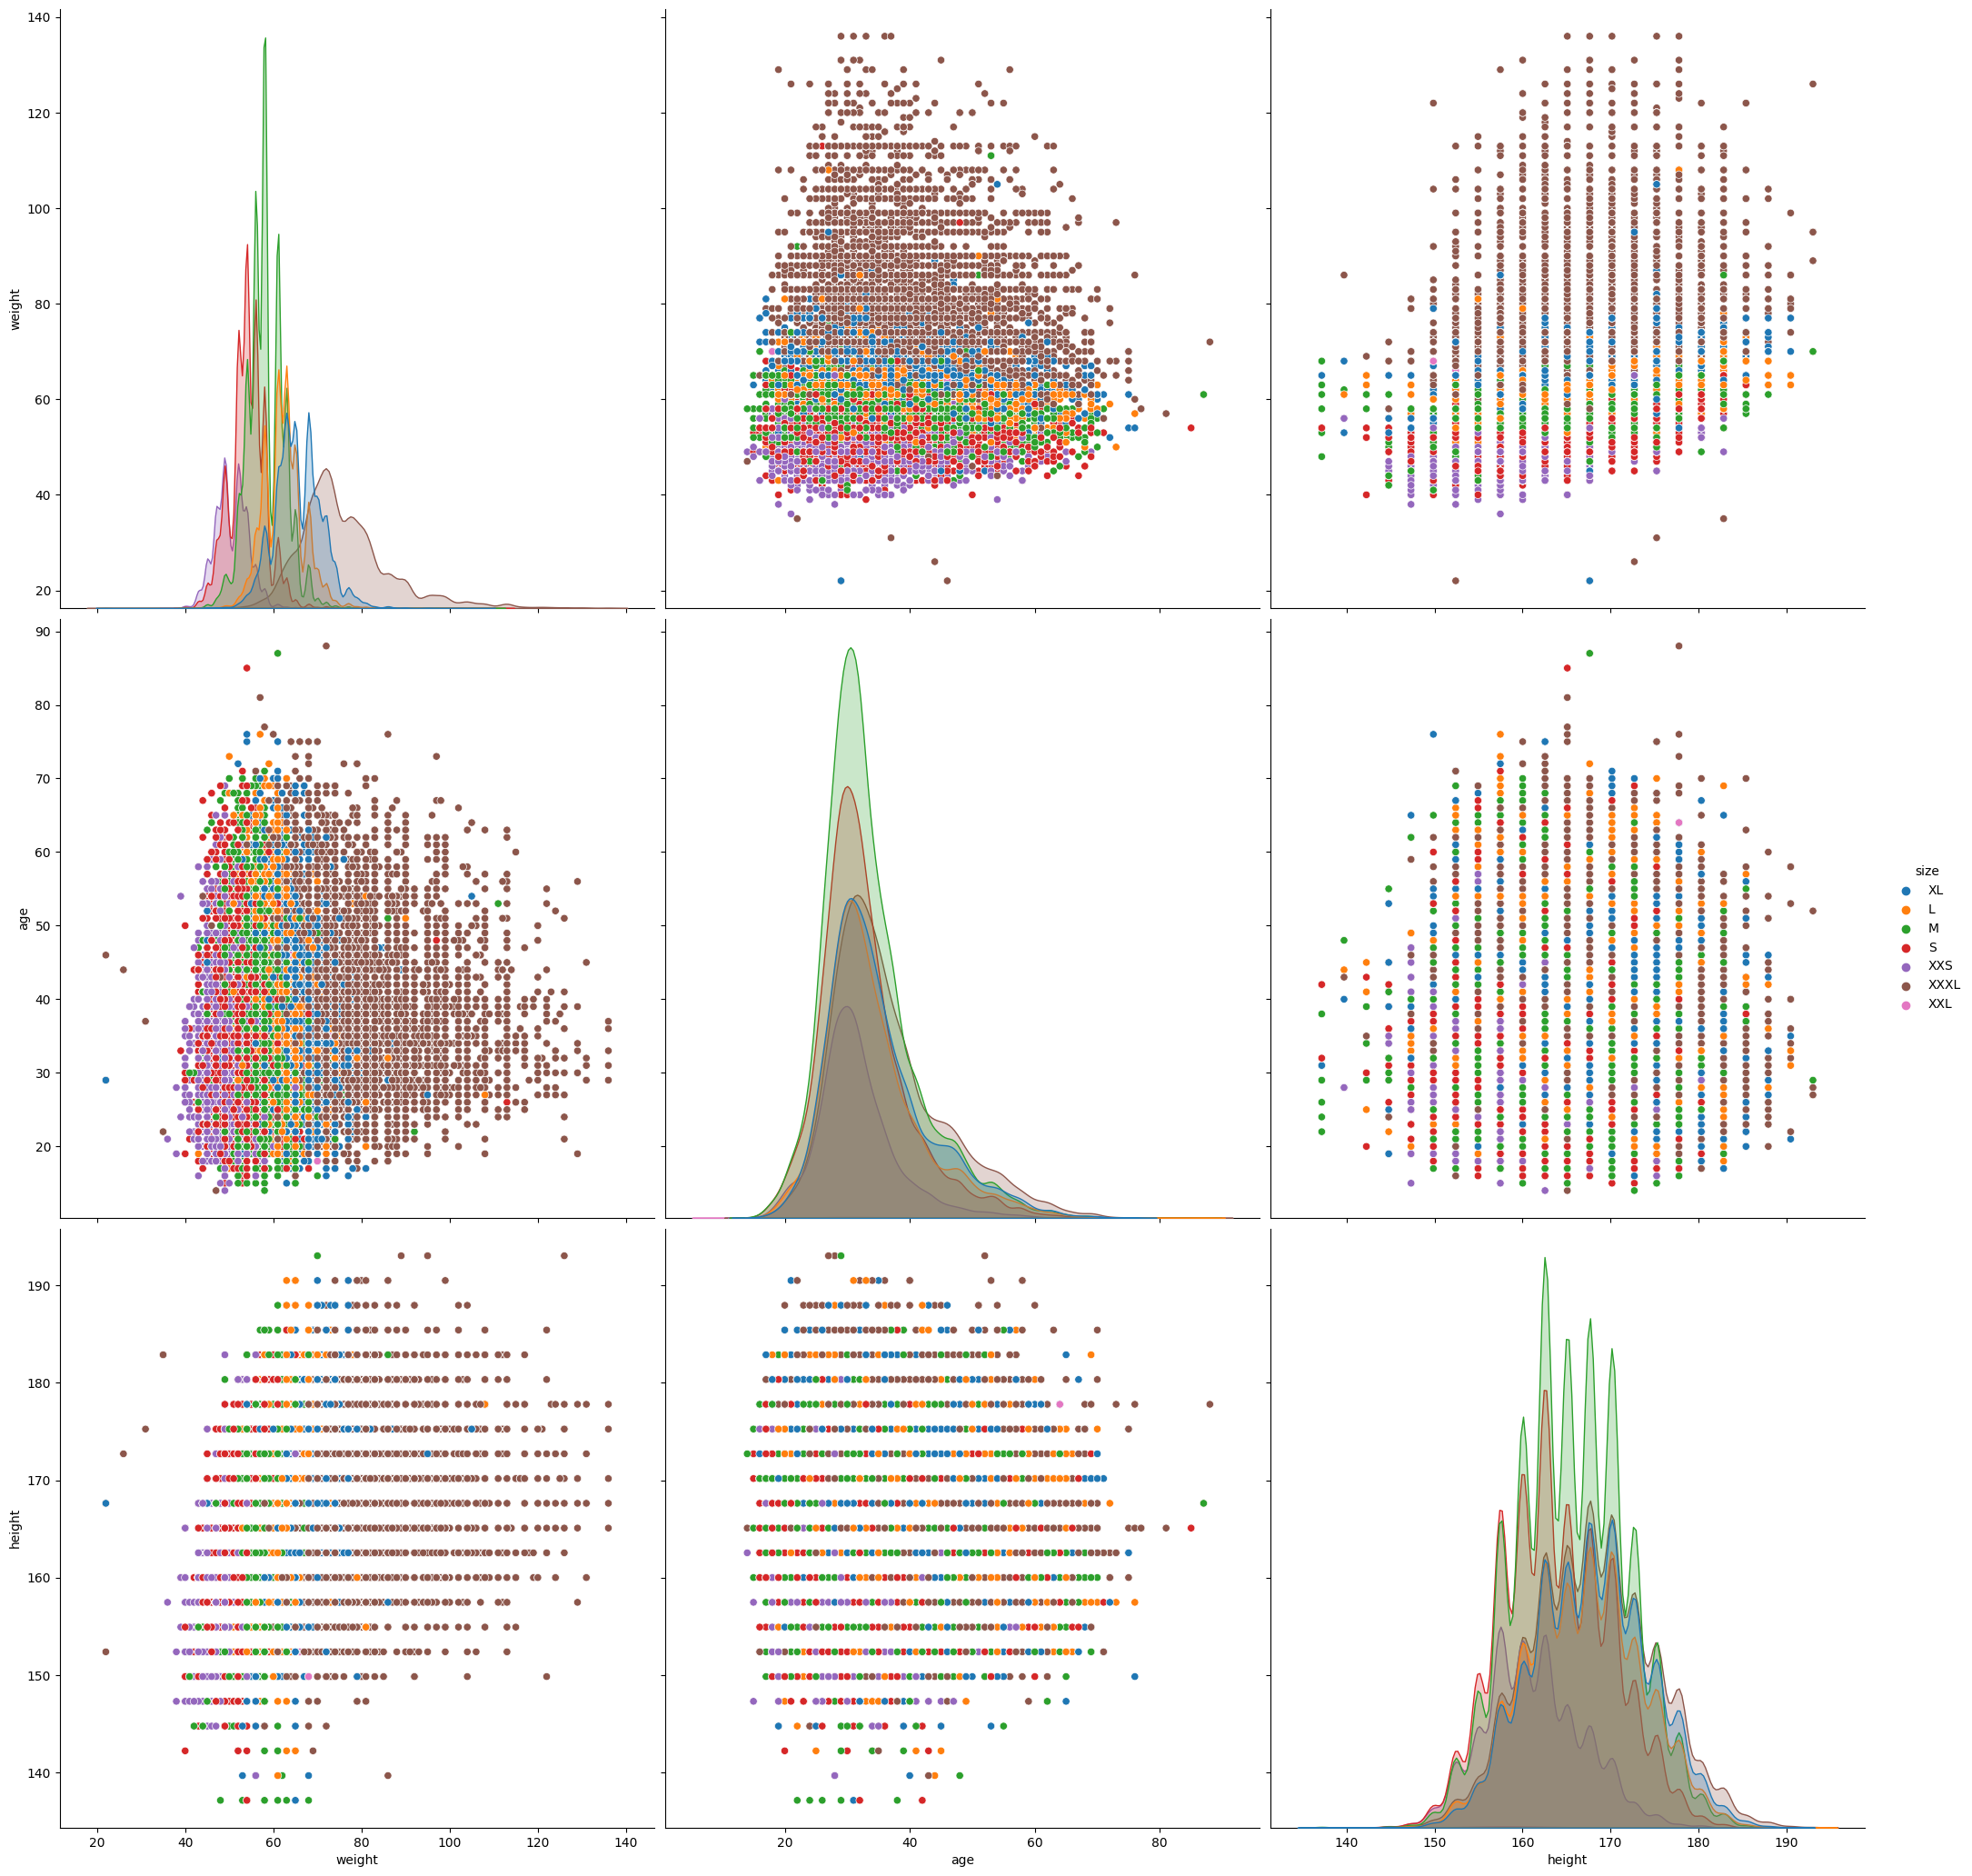

In [3]:
# Overview of data
sns.pairplot(data=df, hue='size', height=7)

# 3-D Visualization

In [4]:
# getting the unique sizes present in the dataset and turning the string labels into int labels 
SizeChart = [];
for label in df['size']:
    if label == 'XXS':
        SizeChart.append(1)
    if label == 'S':
        SizeChart.append(2)
    if label == 'M':
        SizeChart.append(3)
    if label == 'L':
        SizeChart.append(4)
    if label == 'XL':
        SizeChart.append(5)
    if label == "XXL":
        SizeChart.append(6)
    if label == "XXXL":
        SizeChart.append(7)
        
df['SizeLabels'] = SizeChart
SizeTicks = ['XXS','S', 'M', 'L', 'XL', 'XXL', 'XXXL']


# Declaring a plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(projection='3d')

# 3d Scatter plot of age, height, weight
ax.scatter(xs=df['SizeLabels'], ys=df['weight'], zs=df['age'], c=df['height'], s=10)
ax.set_facecolor('white')
ax.set_zlabel("Age")
ax.set_ylabel("Weight")
ax.set_xlabel('Size')
ax.set_title('Size Distrubtion')
ax.view_init(15, 300)

Height was used as the hue for this graph!

**Key take aways for me**
- Weight seems to have the largest effect on size difference
- Age has little effect on size in most cases
- height and weight seem to be strongly correlated

In [5]:
# dropping the size column with strings for ease of Visualizarion
plt_df = df.drop('size',axis=1)
plt_colnames = ['Weight (kg)', 'Age (Years)','Height (cm)','Size Labels']
plt_df.columns = plt_colnames


# Plot of all 4 meterics to understand the data
fig, ax = plt.subplots(2,2, figsize=(15,18))

it = 0

for x in range(2):
    for y in range(2):
        # Defaulting the bin value to 20
        num_bin = 40
        
        # Setting up the iteration loop so that it is always +1
        colname = plt_colnames[it]
        
        # grabbing the min and max values
        min_val = plt_df[colname].min()
        max_val = plt_df[colname].max()
        val_width = max_val - min_val
        
        # Changing the number of bins for the size plot
        if it == 3:
        
            sns.countplot(x=colname,
                          data=plt_df,
                          ax = ax[x,y])
            ax[x,y].set(title=colname)
            pass    
                          
        # setting the bin width to the number of bins present in the data
        bin_width = val_width/num_bin
        
    
        # plotting the graph
        if it < 3:
            if it  == 2:
                num_bin = 10
            sns.histplot(plt_df[colname],
                         bins = num_bin,
                         binrange=(min_val, max_val),
                         ax = ax[x,y])
            
            ax[x,y].set(title=colname)
        
        # counter
        it+=1

**Key take aways for me**
- Shows the skewness of the data pretty well, strong right skew on age and weight
- Size "6" or XXL has a extremely low repesentation in this dataset and can be removed (though you can keep it in!)
- This shows a justification for some pre-processing in order to have a more repersentive model

# --- Data Prep aka the fun stuff! ---

In [6]:
# Prepping Dataframe
pre_df = df.drop("size", axis=1)
# Looking at skew measurement
for columns in pre_df:
    print( "Before: " +pre_df[columns].skew().astype(str)) 

Before: 1.372877280084706
Before: 1.1745130579572616
Before: 0.14413854809371343
Before: 0.42931027072851324


A strong measurement of skew is noted to be > 1 || < -1 

To address this I go for a **log transform** which is the a strong corrector of right skew

[See here for more information on transforms](http://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)


In [7]:
# addressing this through log transfrom
for columns in pre_df:
    # only applying the transform to the first two columns
    if columns == "SizeLabels" or columns == "height":
        pass
    else:
        pre_df[columns] = np.log(pre_df[columns])
        print( "After: "+pre_df[columns].skew().astype(str))

After: 0.6855858369550002
After: 0.43110652978613323


This is more managable degree of skew if we want to address outliers.

**Key Take Away**
- The less skewed your data, the more accurate outlier corrects will become

In [8]:
# Addressing outliers through std method (95%)
for column in pre_df:
    if column == "SizeLabels":
        pass
    else: 
        pre_df = pre_df[pre_df[column] < ( pre_df[column].mean() + (3*pre_df[column].std()))]
        pre_df = pre_df[pre_df[column] > ( pre_df[column].mean() - 3*pre_df[column].std())]   
        # Checking
        print(pre_df[pre_df[column] > ( pre_df[column].mean() + 3*pre_df[column].std())])
        print(pre_df[pre_df[column] < ( pre_df[column].mean() - 3*pre_df[column].std())])
        
print("\n", pre_df)

          weight       age  height  SizeLabels
91      4.553877  3.761200  172.72           7
121     4.553877  3.401197  160.02           7
196     4.553877  3.178054  175.26           7
628     4.553877  3.332205  167.64           7
696     4.553877  3.367296  170.18           7
...          ...       ...     ...         ...
118438  4.564348  3.970292  157.48           7
118768  4.543295  3.332205  162.56           7
118993  4.553877  3.295837  172.72           5
119126  4.553877  3.871201  157.48           7
119178  4.553877  3.555348  167.64           7

[336 rows x 4 columns]
Empty DataFrame
Columns: [weight, age, height, SizeLabels]
Index: []
          weight       age  height  SizeLabels
1376    4.143135  4.158883  162.56           5
1661    3.912023  4.158883  165.10           3
3819    4.060443  4.158883  172.72           3
5983    4.174387  4.158883  170.18           4
6305    4.025352  4.158883  160.02           7
...          ...       ...     ...         ...
111182  4.1108

I have reduced my dataset to only repersent 95% of the overall population so any my models accuracy on the whole data set is its score * 95% for the population as a whole!

**Key take away**
- When you reduce the size of the data set you should also reduce the accuracy score of model accordingly

In [9]:
# Preping the data
Features = pre_df.drop('SizeLabels', axis = 1)

# seperating out the labels
labels = pre_df['SizeLabels']

# Generating test set and training set (trainf)
trainingFeatures, testingFeatures, trainingLabels, testingLabels = train_test_split(Features, labels, test_size = .2, random_state=42)

# now we gonna set up a scale for the values!
scaler = StandardScaler()

# Scaling the features after splitting them
trainingFeatures = scaler.fit_transform(trainingFeatures)
testingFeatures = scaler.transform(testingFeatures)


# Model Time!

# Neighboors

In [10]:
# KNeighboors Classifer
from sklearn.neighbors import KNeighborsClassifier 
# These are used to keep track of the best score obtained by the model
BestN = 0
prev = 0
accuracy = []

for x in range(80,150,5):
    # Declare a model
    model = KNeighborsClassifier(n_neighbors=x, metric='manhattan', weights='uniform') 

    # Fit the model
    model.fit(trainingFeatures, trainingLabels)

    # Trying to predict the model
    score = model.score(testingFeatures,testingLabels) * 100
    # Iteritive testing for nieghbors score
    if score > prev:
        prev = score
        BestN = x
    # Creating meterics to identify optimal neighbors
    accuracy.append(score)

# For model comparision
clusterScore = (np.mean(accuracy))

# Printing best score
print(BestN, " is the best number of neighbors with a score of: ", prev)

100  is the best number of neighbors with a score of:  51.43320252516636


# Graphing the preformace of difference number of clusters

In [11]:
# Graphing model preformace
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot()
ax.plot(range(80,150,5),accuracy)
ax.set_title('Model Accuracy')
ax.set_xlabel('Number of clusters')
ax.set_xticks(range(80,150,5))
ax.set_ylabel('Accuracy (%)')

Text(0, 0.5, 'Accuracy (%)')

In [12]:
# Multiple Linear Regression
from sklearn.linear_model import LinearRegression

# Declare Model
model = LinearRegression()

# Fit Model
model.fit(trainingFeatures, trainingLabels)

# Scoring the model --- 69%
regressionScore = (model.score(testingFeatures,testingLabels)) * 100


# Final Breakdown

**My conclusions**
- When looking at the two models its clear that there just isn't enough parameters
- Regression handles predicting better than clustering with this dataset
- More context to the data would help us better understand how good our model preforms
- A ~65% chance to guess the cloth size of an individual with 7 options is a huge improvement on just guessing!


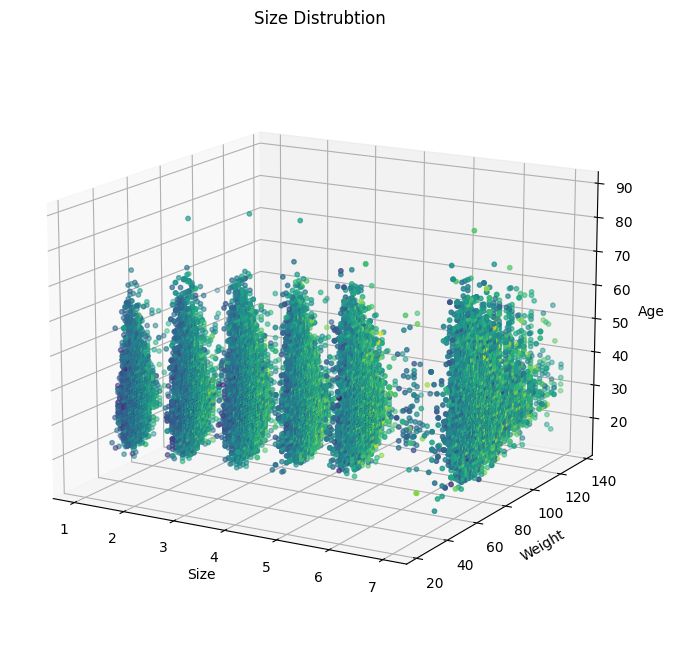

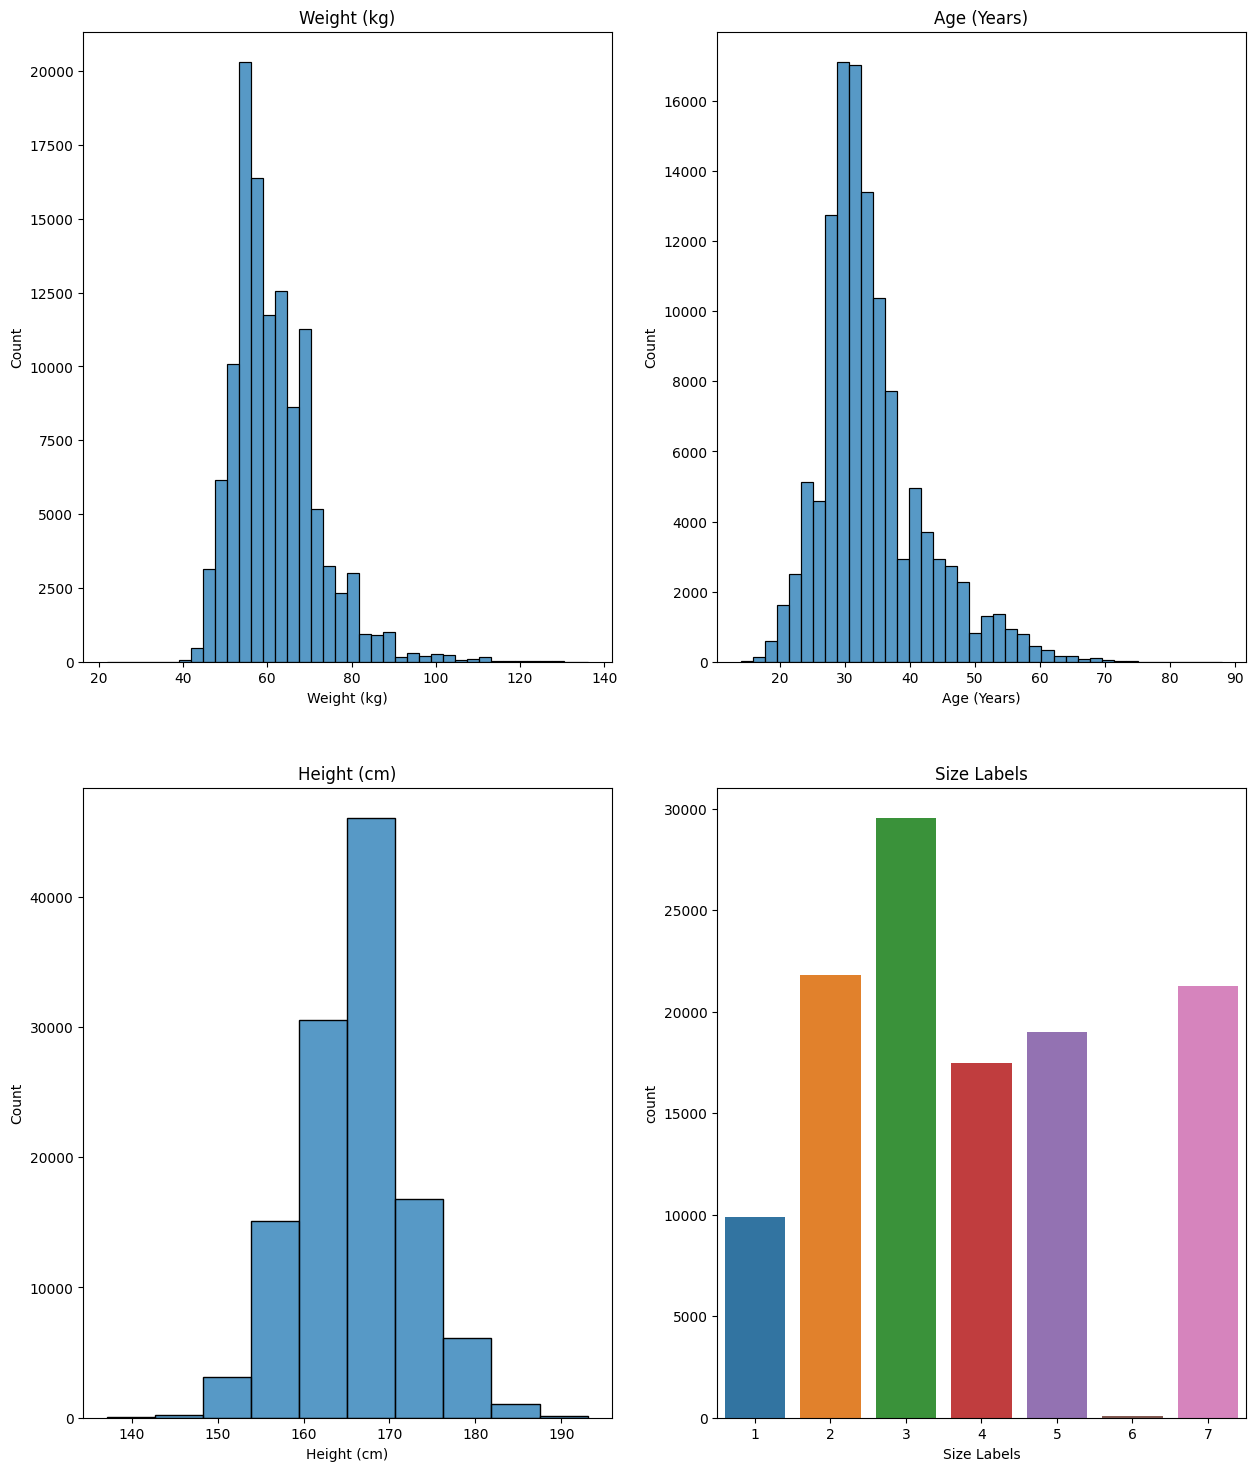

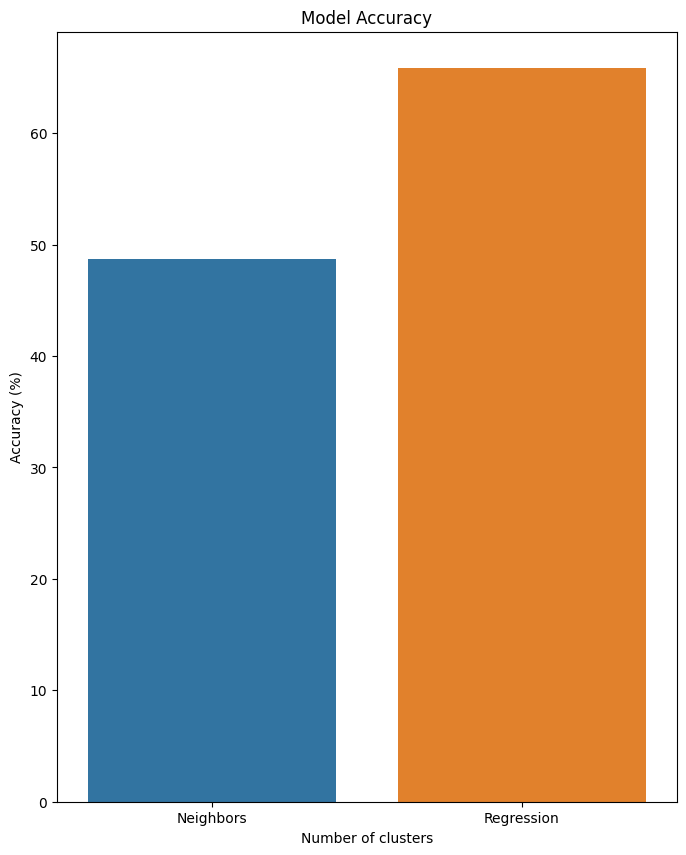

Neighbors method averaged a score of: 51.32047188436883


Regression method average a score of: 69.28438388709893


In [13]:
# Graph comparing the model effectness (95% reflection on the graph!)
Y = [clusterScore*.95, regressionScore*.95]
X = ["Neighbors" , "Regression"]
sns.barplot(y=Y, x=X)
plt.show()
print("Neighbors method averaged a score of: " + clusterScore.astype(str) + "\n\n")
print("Regression method average a score of: " + regressionScore.astype(str))